In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
# Get file path
train = os.path.join("camvid/train/")
train_labels = os.path.join("camvid/train_labels/") 

val = os.path.join("camvid/val/")
val_labels = os.path.join("camvid/val_labels/")

# Get file names
train_fns = os.listdir(train)
train_labels_fns = os.listdir(train_labels)
val_fns = os.listdir(val)
val_labels_fns = os.listdir(val_labels)
print(len(train_fns), len(val_fns))

369 100


## Check Data

<PIL.Image.Image image mode=RGB size=960x720 at 0x1EA9A99F4F0>
(720, 960, 3)
(720, 960, 3)


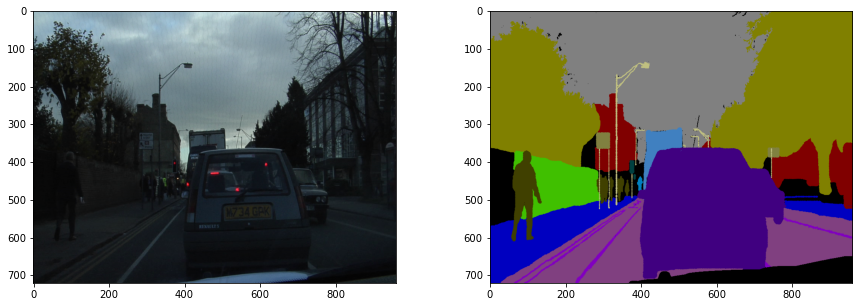

In [4]:
sample_image = os.path.join(train, train_fns[0])
sample_image = Image.open(sample_image).convert("RGB")
sample_label = os.path.join(train_labels, train_labels_fns[0])
sample_label = Image.open(sample_label).convert("RGB")

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(sample_image)

plt.subplot(122)
plt.imshow(sample_label)
print(sample_label)

sample_image = np.array(sample_image)
sample_label = np.array(sample_label)
print(sample_image.shape)
print(sample_label.shape)

In [5]:
np.random.choice(5, 3, p=[0.1, 0, 0.3, 0.6, 0])

array([0, 3, 3])

## Define Labels

In [6]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[ 54  94  53]
 [144 159 199]
 [ 46 150  63]
 [ 40   6 244]
 [221  69 198]]


In [7]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [8]:
label_model.predict(color_array[:5, :])

array([1, 4, 8, 9, 0])

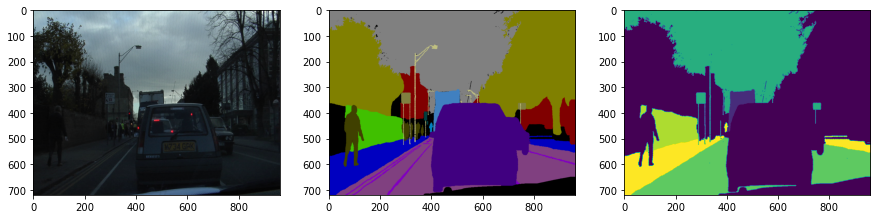

In [9]:
#cityscape, label = split_image(sample_image)

label_class = label_model.predict(sample_label.reshape(-3, 3)).reshape(720, 960)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sample_image)
axes[1].imshow(sample_label)
axes[2].imshow(label_class)

In [10]:
label_class.dtype

dtype('int32')

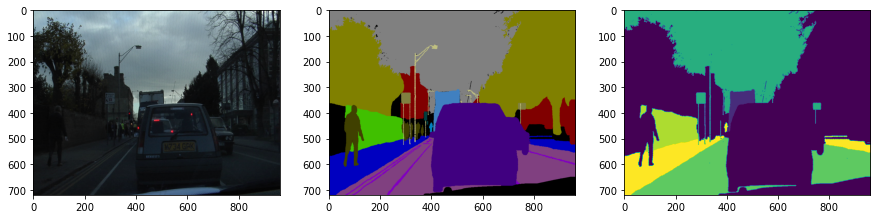

In [11]:
#cityscape, label = split_image(sample_image)

label_class = label_model.predict(sample_label.reshape(-1, 3)).reshape(720, 960)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sample_image)
axes[1].imshow(sample_label)
axes[2].imshow(label_class)

## Define Dataset

In [12]:
class DrivingDataset(Dataset):
    
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_fns = os.listdir(image_dir)
#        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fp = os.path.join(self.image_dir, self.image_fns[index])
        label_fp = os.path.join(self.label_dir, self.image_fns[index].replace(".png", "_L.png"))
        #image = Image.open(image_fp).convert('RGB')
        image = Image.open(image_fp).convert('RGB')
        label = Image.open(label_fp).convert('RGB')
        to_tensor = transforms.ToTensor()
        image = to_tensor(image)
        label = to_tensor(label)
        
        image = np.array(image)
        label = np.array(label)
        #cityscape, label = self.split_image(image)
        #label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        #cityscape = self.transform(cityscape)
        #label_class = torch.Tensor(label_class).long()
        return image, label
    
#    def split_image(self, image):
#        image = np.array(image)
#        cityscape, label = image[:, :256, :], image[:, 256:, :]
#        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [13]:
dataset = DrivingDataset(train, train_labels)
print(len(dataset))

369


In [14]:
image, label = dataset[0]
print(image.shape, label.shape)

(3, 720, 960) (3, 720, 960)


## Model

In [15]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

## Train the model

In [22]:
batch_size = 4
epochs = 10
lr = 0.001

In [23]:
dataset = DrivingDataset(train, train_labels)
data_loader = DataLoader(dataset, batch_size=batch_size)

model = UNET(in_channels= 3, out_channels= 1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [21]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    5772 MB |    5772 MB |    5776 MB |    4352 KB |\n|       from large pool |    5769 MB |    5769 MB |    5774 MB |    4352 KB |\n|       from small pool |       2 MB |       2 MB |       2 MB |       0 KB |\n|---------------------------------------------------------------------------|\n| Active memory         |    5772 MB |    5772 MB |    5776 MB |    4352 KB |\n|       from large pool |    5769 MB |    5769 MB |

In [20]:
import torch
torch.cuda.empty_cache()

import gc
del variables
gc.collect()

NameError: name 'variables' is not defined

In [24]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 676.00 MiB (GPU 0; 8.00 GiB total capacity; 7.19 GiB already allocated; 0 bytes free; 7.20 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF